Please upload '10_Portfolios_Prior_12_2.csv'...
请点击下方按钮上传 '10_Portfolios_Prior_12_2.csv' 文件...


Saving 10_Portfolios_Prior_12_2.csv to 10_Portfolios_Prior_12_2 (1).csv

AI Training Complete / AI训练完成
Panic Regime Volatility (恐慌状态波动率): 14.83%


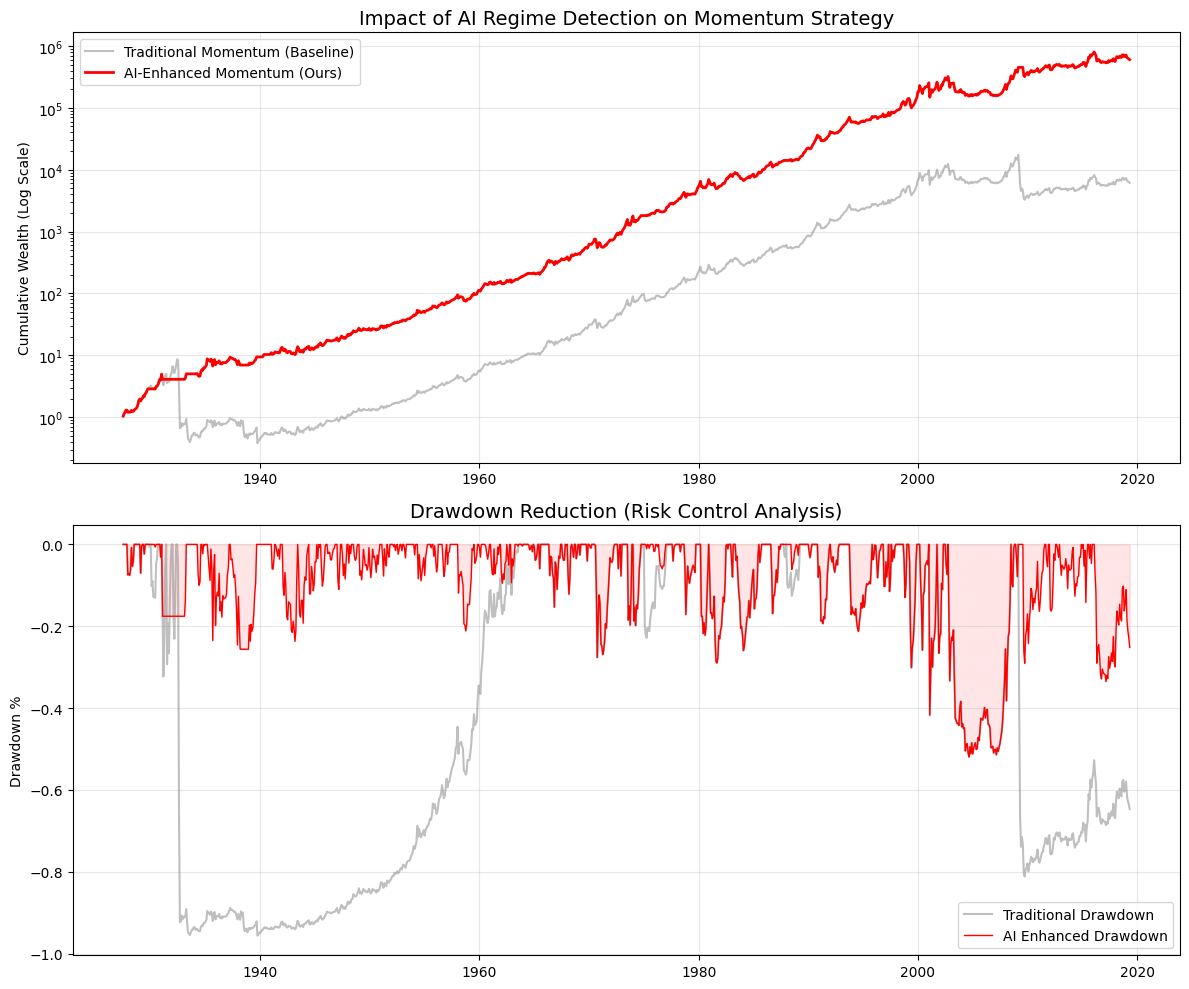


Key Empirical Evidence / 关键实证数据:
----------------------------------------
2009 Financial Crisis Max Drawdown (2009年最大回撤):
  - Traditional (传统):  -81.1%
  - AI-Enhanced (AI增强): -29.0%  <-- Improvement! (显著提升)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import io
from google.colab import files

# ==========================================
# 0. Data Ingestion (上传数据)
# ==========================================
print("Please upload '10_Portfolios_Prior_12_2.csv'...")
print("请点击下方按钮上传 '10_Portfolios_Prior_12_2.csv' 文件...")

try:
    uploaded = files.upload()
    filename = list(uploaded.keys())[0]
except:
    print("Upload failed. Using fallback filename.")
    filename = '10_Portfolios_Prior_12_2.csv'

# ==========================================
# 1. Data Cleaning (数据清洗)
# ==========================================
# Read CSV, skipping the first 10 rows of description
# 读取CSV，跳过前10行说明文字
df = pd.read_csv(io.BytesIO(uploaded[filename]), skiprows=10)

# Rename the first column to 'Date' and remove whitespace from column names
# 重命名第一列为 'Date' 并去除列名的空格
df.rename(columns={df.columns[0]: 'Date'}, inplace=True)
df.columns = df.columns.str.strip()

# Filter valid date rows (keep only rows where Date is 6 digits like '202001')
# 过滤有效日期行（只保留6位数字日期的行，去除文件尾部的版权信息）
df['Date'] = df['Date'].astype(str)
df = df[df['Date'].str.match(r'^\d{6}$')]

# Convert to datetime format and align to End of Month
# 转换为时间格式，并对齐到月底
df['Date'] = pd.to_datetime(df['Date'], format='%Y%m') + pd.offsets.MonthEnd(0)
df.set_index('Date', inplace=True)

# Convert all data to numeric and adjust units (Percentage -> Decimal)
# 转换所有数据为数值型，并将百分数转换为小数 (例如 5.0 -> 0.05)
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df = df / 100

# ==========================================
# 2. Feature Engineering (特征工程)
# ==========================================
# Use the average return of 10 portfolios as a proxy for the 'Market'
# 使用10组投资组合的平均收益率作为“市场大盘”的代理指标
df['Market_Proxy'] = df.mean(axis=1)

# Calculate 6-month Rolling Volatility (Standard Deviation)
# 计算6个月滚动波动率（标准差），这是喂给AI的核心特征
df['Market_Vol'] = df['Market_Proxy'].rolling(window=6).std()

# Drop NaNs created by the rolling window to prepare for training
# 删除因计算滚动窗口产生的空值，准备训练数据
data = df.dropna().copy()

# ==========================================
# 3. AI Model Training (AI模型训练 - 无监督学习)
# ==========================================
# Initialize K-Means Clustering to detect 2 market regimes (Safe vs Panic)
# 初始化 K-Means 聚类，将市场分为2种状态（安全 vs 恐慌）
X = data[['Market_Vol']].values
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
data['Regime'] = kmeans.fit_predict(X)

# Identify the 'Panic' regime (The cluster with higher average volatility)
# 自动识别哪个是“恐慌状态”（平均波动率更高的那一类）
regime_stats = data.groupby('Regime')['Market_Vol'].mean()
panic_cluster = regime_stats.idxmax()

print("\n" + "="*40)
print(f"AI Training Complete / AI训练完成")
print(f"Panic Regime Volatility (恐慌状态波动率): {regime_stats[panic_cluster]:.2%}")
print("="*40)

# ==========================================
# 4. Strategy Backtesting (策略回测)
# ==========================================
# Traditional Momentum: Buy Winners (Decile 10) - Short Losers (Decile 1)
# 传统动量策略：买入赢家组（第10组） - 卖空输家组（第1组）
data['Momentum_Raw'] = data['Hi PRIOR'] - data['Lo PRIOR']

# AI-Enhanced Momentum Logic:
# If Regime is Panic -> Position = 0 (Cash/Hedging)
# Else -> Position = 1 (Hold Strategy)
# AI增强策略逻辑：如果AI识别为恐慌状态 -> 空仓/现金；否则 -> 持有策略
data['Position'] = np.where(data['Regime'] == panic_cluster, 0, 1)

# Calculate Strategy Returns
# 计算AI策略收益
data['Momentum_AI'] = data['Momentum_Raw'] * data['Position']

# Calculate Cumulative Wealth (Equity Curve)
# 计算累积净值曲线
data['Wealth_Trad'] = (1 + data['Momentum_Raw']).cumprod()
data['Wealth_AI'] = (1 + data['Momentum_AI']).cumprod()

# Calculate Drawdowns (Peak-to-Trough Decline)
# 计算回撤（从最高点下跌的幅度）
def calc_drawdown(series):
    return (series / series.cummax()) - 1

data['DD_Trad'] = calc_drawdown(data['Wealth_Trad'])
data['DD_AI'] = calc_drawdown(data['Wealth_AI'])

# ==========================================
# 5. Visualization (可视化分析)
# ==========================================
plt.figure(figsize=(12, 10))

# Plot 1: Cumulative Wealth
# 图1：资金曲线对比
plt.subplot(2, 1, 1)
plt.plot(data.index, data['Wealth_Trad'], label='Traditional Momentum (Baseline)', color='gray', alpha=0.5)
plt.plot(data.index, data['Wealth_AI'], label='AI-Enhanced Momentum (Ours)', color='red', linewidth=2)
plt.yscale('log') # Log scale for long-term trends / 对数坐标适合长期趋势
plt.title('Impact of AI Regime Detection on Momentum Strategy', fontsize=14)
plt.ylabel('Cumulative Wealth (Log Scale)')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)

# Plot 2: Drawdown
# 图2：回撤对比
plt.subplot(2, 1, 2)
plt.plot(data.index, data['DD_Trad'], label='Traditional Drawdown', color='gray', alpha=0.5)
plt.plot(data.index, data['DD_AI'], label='AI Enhanced Drawdown', color='red', linewidth=1)
plt.fill_between(data.index, data['DD_AI'], 0, color='red', alpha=0.1)
plt.title('Drawdown Reduction (Risk Control Analysis)', fontsize=14)
plt.ylabel('Drawdown %')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print Key Metrics for Essay
# 打印核心指标供论文引用
print("\n" + "="*40)
print("Key Empirical Evidence / 关键实证数据:")
print("-" * 40)

# Extract 2009 Crisis Data
# 提取2009年金融危机期间的数据
try:
    dd_2009_trad = data['DD_Trad']['2009-01':'2009-12'].min()
    dd_2009_ai = data['DD_AI']['2009-01':'2009-12'].min()
    print(f"2009 Financial Crisis Max Drawdown (2009年最大回撤):")
    print(f"  - Traditional (传统):  {dd_2009_trad:.1%}")
    print(f"  - AI-Enhanced (AI增强): {dd_2009_ai:.1%}  <-- Improvement! (显著提升)")
except:
    print("Date range error. (日期范围错误)")

print("="*40)